In [219]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#datadir = '/home/mer49/Dropbox (Cambridge University)/Shared/Prannoy/Code/20200317 MER GPs/'
datadir = "/home/cfs/mer49/gp/"

from util            import *
from basics          import *
from simulate_data   import *
from estimators      import *
from config          import *
from scipy.special   import *
from functools       import lru_cache as cache
from opt_einsum      import contract
from scipy.io        import loadmat
from IPython.display import clear_output
configure_pylab()

# This code benefits considerably from using single-precision floating point
# Jax's fft is slow
# Numpy's fft pathologically casts to float64
# Scipy's seems ok
from scipy.fft import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set constants

In [216]:
tol    = 1e-6      # Newton convergence tolerance
mintol = 1e-7      # Minimum residual tolerance
L      = 128       # Grid size ( bins per linear distance )
T      = L*L       # Total number of basis functions (bins per unit area)
res    = 50        # Upsampling/interpolation resolution when estimating period
pad    = 0.6       # Pad to avoid wrap-around from circular convolution; 0.5 = no padding
Fs     = 50.0      # Sample rate of data in Hz ( samples/second )
Δt     = 1/Fs      # seconds / sample
Fl     = 0.25      # Low-frequency cutoff in Hz for smoothing path trajcetory for heading

# Find and load data

In [218]:
# 2D grid coordinates as complex numbers
coords = zgrid(L)
bins   = linspace(0,1,L+1,dtype='float32')

# Resolution for the camera used to record R1 is 350px/m;
# resolution for other rats (R11 and R18) was 338px/m
#px_p_meter = 338
#dataset    = 'R18_20200131_1to2_EC_good.mat'
#px_p_meter = 338
#dataset    = 'R11_20190607_1to2_EC_good.mat'
px_p_meter  = 350
dataset     = 'R1_20190823_2to1_EC_good.mat'
datasetname = dataset.split('_')[0]
dataset_ID  = re.match('(R\d+)_(\d+)',dataset).group(0)

# Load all datasets from this day
data = loadmat(datadir+dataset,squeeze_me=True)
xy50 = data['xy50'] # Position
sp50 = data['sp50'] # Spikes
hd50 = data['hd50'] # Head angle
ndatasets  = len(xy50)

# Which datasets to process? 
do_datasets = [1]#range(ndatasets)

# Rescale location data from all datasets using same transformation
allxy50 = np0.concatenate(xy50)
x,y     = allxy50.T
minx,maxx,miny,maxy = np.min(x),np.max(x),np.min(y),np.max(y)
delta   = np0.max([maxx-minx,maxy-miny])
scale   = (1-1e-6)/(delta*pad*2)

# Record grid scale
bins_p_meter = scale*L*px_p_meter
cm_p_bin     = 100/bins_p_meter
print('cm  per spatial bin',cm_p_bin)
print('cm² per spatial bin',cm_p_bin**2)

# Load a given dataset, rescaling the spatial locations
def load_dataset(fn,dataindex):
    # Get dataset
    data = loadmat(fn,squeeze_me=True)
    xy50 = data['xy50'] # Position
    sp50 = data['sp50'] # Spikes
    hd50 = data['hd50'] # Head angle
    # Get specified dataset
    x,y  = xy50[dataindex].T
    s    = sp50[dataindex]
    x    = (x-(maxx+minx)/2+delta*pad)*scale
    y    = (y-(maxy+miny)/2+delta*pad)*scale
    return s,x,y,scale

def bin_spikes(x,y,s,bins,w=None):
    # Bin spike counts
    N    = histogram2d(y,x,(bins,bins),density=0,weights=w)[0]
    ws   = s if w is None else array(s)*array(w)
    K    = histogram2d(y,x,(bins,bins),density=0,weights=ws)[0]
    return N,K

# Get specific dataset
idata = do_datasets[0]
s,x,y,scale = load_dataset(datadir+dataset,idata)

# Grab spikes
st    = find(s>0)              # samples with a spike
xs,ys = x[st],y[st]            # locations where spikes happened
sk    = s[st]                  # number of spikes per spike event
N,K   = bin_spikes(x,y,s,bins) # count number of visits and number of spikes per bin
mask  = blur(N>0,2)>0.1        # mask out areas with no data
y     = nan2num(K/N)        # spikes/sample

# Calibrate grid scale
λhat   = y
acorr2 = fft_acorr(λhat,mask) # Get 2D autocorrelation
acorrR = radial_average(acorr2) # Get radial autocorrelation
res    = 50                     # Subsampling resolution
P,acup = acorr_peak(acorrR,res) # Distance to first peak in bins
print('Period is %f cm (%f bins)'%(P*cm_p_bin,P))

subplot(121)
imshow(acorr2)
axis('off')
subplot(122)
plot((arange(L)-L/2)*cm_p_bin,acorrR)
plot((linspace(-L/2,L/2,L*res))*cm_p_bin,acup)
xlim(-L/2*cm_p_bin,L/2*cm_p_bin)
xlabel('Δcm')
ylabel('spikes²/second²')
axvline(P*cm_p_bin,color='k',lw=0.5)

cm  per spatial bin 3.1682123531314383
cm² per spatial bin 10.037569514534646


NameError: name 'nan2num' is not defined

Text(0.5, 0.98, 'R1_20190823_2to1_EC_good.mat dataset 1')

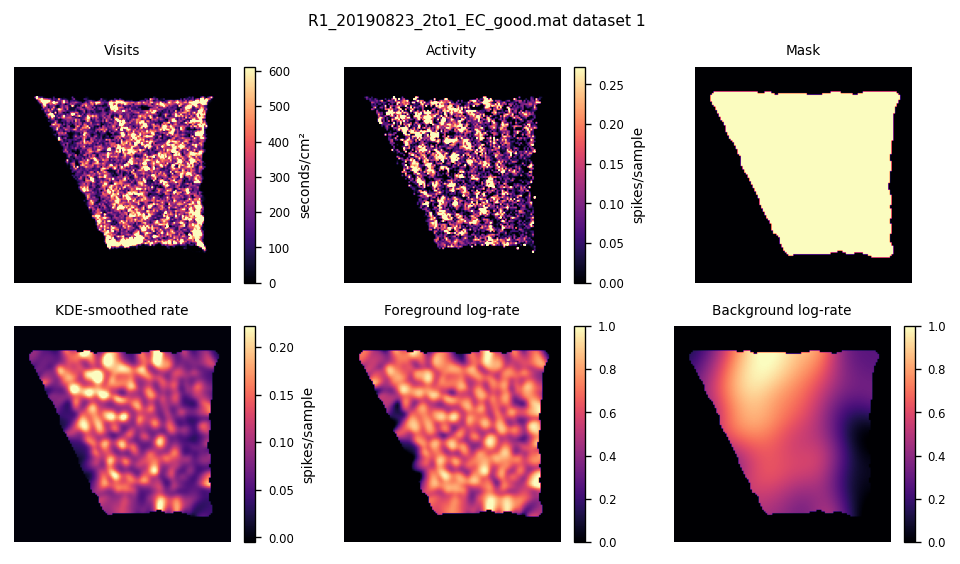

In [81]:
# Precompute variables; Passed as globals to jac/hess
fgσ  = P/pi           # In units of linear-bins
bgσ  = fgσ*5          # In units of linear-bins
n    = N.ravel()      # seconds/bin
y    = y.ravel()      # spikes/second within each bin
λhat = kdeλ(N,K,fgσ)  # KDE estimated rate
λbg  = kdeλ(N,K,bgσ)  # Background rate
lλh  = slog(λhat)     # Log rate
lλb  = slog(λbg)      # Log background
lλf  = lλh - lλb      # Foreground log rate
Δx   = cm_p_bin**2

# Initial guess for kernel height
σ0   = zerolag(radial_acorr(lλf,mask))

figure(figsize=(7,4))
subplot(231)
title('Visits');
axis('off')
imshow(N*Δx,vmin=percentile(N*Δx,5),vmax=percentile(N*Δx,95));
colorbar(label='seconds/cm²')
subplot(232)
title('Activity');
axis('off')
imshow(y.reshape(L,L),vmin=percentile(y,1),vmax=percentile(y,95));
colorbar(label='spikes/sample')
subplot(233)
showim(mask,'Mask');
subplots_adjust(top=0.8)
suptitle('%s dataset %d'%(dataset,idata))
subplot(234)
title('KDE-smoothed rate');
axis('off')
imshow(λhat*mask,vmin=percentile(λhat,1),vmax=percentile(λhat,99));
colorbar(label='spikes/sample')
subplot(235)
showim(lλf,'Foreground log-rate',mask=mask);
colorbar()
subplot(236)
showim(lλb,'Background log-rate',mask=mask);
colorbar()
tight_layout()
suptitle('%s dataset %d'%(dataset,idata))

# Define hyperparameter search grid

- β is the kernel height
- P is the kernel period

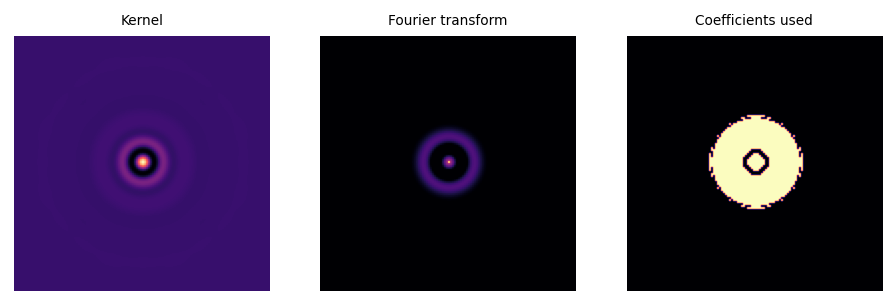

In [199]:
rP   = sqrt(2)
rβ   = 2
P_lo = P/rP
P_hi = P*rP
β_lo = 1/rβ
β_hi = 1*rβ
NP   = 11
Nβ   = 11
Ps   = float32(exp(linspace(log(P_lo),log(P_hi),NP)))
βs   = float32(exp(linspace(log(β_lo),log(β_hi),Nβ))[::-1])

@cache(NP*2)
def make_kernel_ft(L,P,σ0,dc=1e1,k=3):
    '''
    This kernel is calibrated in z space
    '''
    coords   = zgrid(L)
    window   = hanning(L)
    window   = fftshift(outer(window,window))
    kern     = j0(fftshift(abs(coords*2*pi/P)))*window
    clip     = fftshift(abs(coords)<P*jn_zeros(0,k)[-1]/(2*pi))
    kern     = kern*clip
    kern     = blur(kern,P/pi)
    kern     = repair_small_eigenvalues(kern*σ0/np.max(kern),1e-5)
    Kf       = np0.array(real(fft2(kern)))
    Kf[0,0] += dc
    return Kf

use2d = zeros((L,L),dtype='bool')
for p in Ps:
    Kf  = make_kernel_ft(L,p,σ0)
    thr = np.max(array(sorted(abs(Kf).ravel()))[:-1])
    thr = percentile(abs(Kf).ravel(),95)
    use2d |= (abs(Kf))>thr

# Define low-rank Fourier space projection 
use2d   = use2d | use2d.T    # Ensure symmetric
use     = find(use2d.ravel()) # Indecies into LxL array to use4
R        = len(use)            # Number of components used
down     = eye(T)[use]         # Matrix to trim down a Fourier transform 

# Define low-rank cuts for 1D transform
use1d  = any(use2d,axis=0)                 # Indecies to use along L
R1d    = sum(use1d)                        # Number of components used in the 1D tranform
usecut = find(use2d[:,use1d][use1d,:])     # Subset of reduced 1Dx1D transform kept in full 2D transform

# Streamline precomputation of low-rank collapse of diagonal matrix
f1e = fft(eye(L),norm='ortho')[use1d,:]
f2e = f1e[:,None,:,None]*f1e[None,:,None,:]
h2e = f2e.real + f2e.imag
h2e = h2e.reshape(R1d*R1d,L*L)[usecut]

def reverse(A):
    # Exchange positive and negative frequencies in a 2D fourier transform
    return roll(roll(A[::-1,:],1,axis=0)[:,::-1],1,axis=1)

# Positive/negative frequency flip in reduced representation
hperm = int32(down@reverse((down.T@(arange(R))).reshape(L,L)).ravel())

def er(a,b): print(max(abs(a-b)))
def hcv(kh,xh):
    kh = kh/2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)*xh+(kh-kr)*xr
def hcm(kh,xh):
    kh = kh/2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)[:,None]*xh+(kh-kr)[:,None]*xr
def Ftv(v):  # Collapse vector DOWN
    return fhtv(v)[use]
def Fv(v):
    #return fhtv(zeros(T).at[use].set(v))
    x = zeros(T)
    x[use] = v
    return x
def fhtv(v):
    v = fft2(v.reshape(L,L),norm='ortho').ravel()
    return v.real+v.imag
def fhtA(x):
    x = fft2(x.reshape(x.shape[0],L,L),norm='ortho').reshape(x.shape[0],T)
    return x.real+x.imag
def FtA(A):  # Collapse matrix DOWN
    return fhtA(A.T).T[use,:]
def FA(A): 
    # Syntax for jax
    # return fhtA(zeros((T,A.shape[-1])).at[use,:].set(A).T).T
    X = zeros((T,A.shape[-1]))
    X[use,:] = A
    return fhtA(X.T).T
def dv(Q):
    return sum(FA(tril(Q))**2,1)
def chol(x):
    return numpy.linalg.cholesky(x)
def ltinv(ch):
    q,info = scipy.linalg.lapack.dtrtri(ch,lower=True)
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return q
def cv(K,v):
    return real(ifft2(fft2(v.reshape(L,L),norm='ortho')*K,norm='ortho')).ravel()
def cm(K,M):
    return real(ifft2(
        K[:,:,None]*fft2(M.reshape(L,L,M.shape[-1]),axes=(0,1)),
        axes=(0,1))).reshape(T,M.shape[-1])
def logdet(A):
    return sum(slog(diag(chol(A))))*2
def chinv(X):
    X = float64(X)
    X = scipy.linalg.cholesky(X,lower=True)
    X,info = scipy.linalg.lapack.dtrtri(X,lower=True)
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return X
def down(u):
    u = fft2(u.reshape(L,L),norm='ortho')[use2d]
    return u.real + u.imag
def up(u):
    x = zeros((L,L))
    x[use2d] = u
    x = fft2(x,norm='ortho').ravel()
    return x.real + x.imag
def vz2u(v):
    assert(len(v.ravel()==L*L))
    return v#/L
def vu2z(v):
    assert(len(v.ravel())==L*L)
    return v#*L
def vu2h(v):
    assert(len(v.ravel())==L*L)
    return down(v)
def vh2u(v):
    assert(len(v)==R)
    return up(v)
def vz2h(v):
    return vu2h(vz2u(v))
def vh2z(v):
    return u2z(h2u(v))
def Kz2u(K):
    assert(len(K.ravel())==L**2)
    return K#/L**2
def Λz2u(Λ):
    assert(len(Λ.ravel())==L**2)
    return K#*L**2
Ku2z = Λz2u
Λu2z = Kz2u

# Precompute all manner of useful forms of a kernel
# TODO: check whether all of these are used
# Calculations say
# Multiply kernel by L
@cache(NP*2)
def prepare_kernel(p):
    
    # Initial kernel and its inverse are in space Z
    # This space has physical units but is improper, in terms of measure
    Kfz = make_kernel_ft(L,p,σ0)
    K0z = real(ifft2(Kfz))
    
    # We need to convert this to space U
    # To send vectors from Z to U, divide by L
    # To send kernels, divide by L²
    # This transformation is NOT unitary, although it represents
    # a unitary transformation in theory
    K0u = K0z#/L**2
    Kfu = fft2(K0u,norm='ortho').real
    Λfu = 1.0/Kfu
    
    # We need to prepare Hartley-space kernels. 
    Kh = (Kf.real+Kf.imag).ravel()[use]
    Λh = (Λf.real+Λf.imag).ravel()[use]
    
    return K0u,Kfu,Λfu,Kh,Λh

K0u,Kfu,Λfu,Kh,Λh = prepare_kernel(P)
subplot(131)
showkn(K0u,'Kernel')
subplot(132)
showkn(Kfu,'Fourier transform')
subplot(133)
showkn(use2d,'Coefficients used')

In [200]:
def fast_low_rank_covariance(μh,vz,β,p):
    assert(len(μh)==R)
    assert(len(vz)==L*L)
    
    # This needs to operate in space H
    K0u,Kfu,Λfu,Kh,Λh = prepare_kernel(p)

    # But, we need to get the marginal variances in space Z
    μu   = up(μh)
    μz   = vu2z(μu)
    lnλz = μz + μ0z + vz/2
    λz   = exp(lnλz)

    # We can now calculate the Poisson likelihood
    # It introduces the following curvature to the precision matrix
    nλz = n*λz
    
    # Now, we need the image of nλz in space H
    # Σz = diag[nλz]¯¹ is a contribution to the posterior
    # Since this is an inverse, we pick up a scaling of L²
    # TODO: I'm quite turned around on this one
    nλu = nλz#/L**2
     
    # Now, we need to convert to space H
    # We have stored a unitary matrix for this: h2e
    x   = sqrt(nλu)
    x   = x[None,:]*h2e
    xxt = x@x.T
    
    # Finally, we operate in space H
    Λp  = β*diag(Λh) + xxt
    Cp  = chinv(Λp)
    Σp  = Cp.T @ Cp
    
    return Σp

def fast_covariance_diagonal(μh,vz,β,p):
    
    # This needs to operate in space H
    K0u,Kfu,Λfu,Kh,Λh = prepare_kernel(p)

    # But, we need to get the marginal variances in space Z
    μu   = up(μh)
    μz   = vu2z(μu)
    lnλz = μz + μ0z + vz/2
    λz   = exp(lnλz)

    # We can now calculate the Poisson likelihood
    # It introduces the following curvature to the precision matrix
    nλz = n*λz
    
    # Now, we need the image of nλz in space H
    # Σz = diag[nλz]¯¹ is a contribution to the posterior
    # Since this is an inverse, we pick up a scaling of L²
    # TODO: I'm quite turned around on this one
    nλu = nλz#/L**2

    # Now, we need to convert to space H
    # We have stored a unitary matrix for this: h2e
    x   = sqrt(nλu)
    x   = x[None,:]*h2e
    xxt = x@x.T
    
    # Finally, we operate in space H
    Λp  = β*diag(Λh) + xxt
    A   = chinv(Λp)
    X   = zeros((L,L,R))
    
    # We convert back to space U
    X[use2d] = A.T
    DF = fft2(X,axes=(0,1),norm='ortho')
    DF = DF.real + DF.imag
    DF = DF.reshape(T,R).T
    d  = sum(DF**2,0)
    
    # The returned result expects the answer in space Z
    # This is variance though, so we multiply by L^2
    return d#*L**2

def logdet(A):
    return sum(log(diag(scipy.linalg.cholesky(A,lower=True))))*2

def fast_low_rank_inverse_covariance(μh,vz,β,p):
    assert(len(μh)==R)
    assert(len(vz)==L*L)
    
    # This needs to operate in space H
    K0u,Kfu,Λfu,Kh,Λh = prepare_kernel(p)
    
    # But, we need to get the marginal variances in space Z
    μu   = up(μh)
    μz   = vu2z(μu)
    lnλz = μz + μ0z + vz/2
    λz   = exp(lnλz)
    
    # We can now calculate the Poisson likelihood
    # It introduces the following curvature to the precision matrix
    nλz = n*λz
    
    # Now, we need the image of nλz in space H
    # Σz = diag[nλz]¯¹ is a contribution to the posterior
    # Since this is an inverse, we pick up a scaling of L²
    # TODO: I'm quite turned around on this one
    nλu = nλz#/L**2
    
    # Now, we need to convert to space H
    # We have stored a unitary matrix for this: h2e
    x   = sqrt(nλu)
    x   = x[None,:]*h2e
    xxt = x@x.T
    
    # Finally, we operate in space H
    Λp  = β*diag(Λh) + xxt
    return Λp

def loss_optimized(μh,vz,β,p):
    '''
    n'(λ-y∘μ)  ½μ'Λ₀μ ½ln|Σ₀| -½ln|Σ| ½tr[Λ₀Σ]
    '''
    # This needs to operate in space H
    K0u,Kfu,Λfu,Kh,Λh = prepare_kernel(p)

    # Likelihood computed in z space
    μu   = up(μh)
    μz   = vu2z(μu)
    lnλz = μz + μ0z + vz/2
    λz   = exp(lnλz)
    l1   = n@(λz-y*μz)
    
    # We also need to get the marginal variances in space Z
    Λp   = fast_low_rank_inverse_covariance(μh,vz,β,p)
    C    = chinv(Λp)                  
    
    # Now the rest is operating in H space
    l2   = (μh@(Λh*μh))*(β/2)         #  ½ μ'Λ₀μ 
    l3   = sum(log(β*Λh))             #  ½ ln|Σ₀|
    l4   = -sum(log(diag(C)))         # -½ ln|Σ|
    l5   = β*sum(C**2 * Λh.ravel())/2 #  ½ tr[Λ₀Σ]
    
    return array([l1,l2,l3,l4,l5])

In [201]:
tol    = 1e-7
mintol = 1e-9

In [202]:
def infer(μh,β,p,maxiter=100,showprogress=True):  
    β = float(β)
    p = float(p)
    report = print if showprogress else lambda *x:()
    report('(initializing)')
    
    # Prepare kernel
    K0u,Kfu,Λfu,Kh,Λh = prepare_kernel(p)
    Kβ = Kh/β
    Λβ = Λh*β
    
    # Preconditioner, in low-rank space
    M = op(R,lambda u:Kβ*u)
    
    # We need to start at vz = 0 for stability
    vz = zeros(L**2)
    
    report('(optimizing)')
    
    # Interleave mean and variance iterations
    for i in range(maxiter):
        
        # Inner loop optimizes the mean
        for j in range(maxiter):

            # Gradient, in low-rank space
            # We need to get nλ in Z space though
            μu   = up(μh)
            μz   = vu2z(μu)
            lnλz = μz + μ0z + vz/2
            λz   = exp(lnλz)
            nλu  = vz2u(n*λz)
            J    = Λβ*μh + vz2h(n*(λz-y))

            # Hessian, in low-rank space
            def Hu(u):
                return Λβ*u + down(nλu*up(u))

            Δμ = minres(op(R,Hu),J,tol=mintol,M=M)[0]
            μh -= Δμ
            if max(abs(Δμ))<tol: break
            report('μ',max(abs(Δμ)),'iteration',i,j)
            
        # Update the variance estimate
        report('(getting variance)')
        v2 = fast_covariance_diagonal(μh,vz,β,p)
        Δv = v2-vz
        vz = v2
        
        report('Iteration',i)
        report('Δv',max(abs(Δv)))
        report('Δμ',max(abs(Δμ)))
        if max(abs(Δμ))<tol and max(abs(Δv))<tol: break
    
    print(shape(μh))
    return μh,vz,loss_optimized(μh,vz,β,p)

In [203]:
#%load_ext snakeviz
#%snakeviz 
'''
to go from z to w we divide by L
to go from w to z we multiply by L
'''

μz  = lλf.ravel()
μu  = vz2u(μz)
μh  = vu2h(μu)
μ0z = lλb.ravel()
μ0u = vz2u(μ0z)
β   = 1
tic()
μh,vz,l = infer(μh,β,P)
tic('took')

(initializing)
(optimizing)
μ 1123.5496774867154 iteration 0 0
μ 131.05257605295222 iteration 0 1
μ 65.47630086649127 iteration 0 2
μ 24.909323257563784 iteration 0 3
μ 11.055142918290455 iteration 0 4
μ 4.947937734280441 iteration 0 5
μ 2.060630332260214 iteration 0 6
μ 0.8353558808006976 iteration 0 7
μ 0.3696907809659752 iteration 0 8
μ 0.18044651046987872 iteration 0 9
μ 0.10466072438233179 iteration 0 10
μ 0.052616069722906465 iteration 0 11
μ 0.02793345875019506 iteration 0 12
μ 0.01457210592165334 iteration 0 13
μ 0.007745988389689264 iteration 0 14
μ 0.003990425090846854 iteration 0 15
μ 0.0021177500343657753 iteration 0 16
μ 0.0011121353697577964 iteration 0 17
μ 0.0005871086600763713 iteration 0 18
μ 0.0003094672789212235 iteration 0 19
μ 0.00016300073633353468 iteration 0 20
μ 8.580437750891141e-05 iteration 0 21
μ 4.5334091075900866e-05 iteration 0 22
μ 2.3759848634744797e-05 iteration 0 23
μ 1.253892353556387e-05 iteration 0 24
μ 6.598408484179245e-06 iteration 0 25
μ 3.47

161339.591796875

In [204]:
shape(μh),R, L*L, shape(vu2h(μu))

((1529,), 1529, 16384, (1529,))

In [205]:
μu = vh2u(μh)
μz = vu2z(μu)

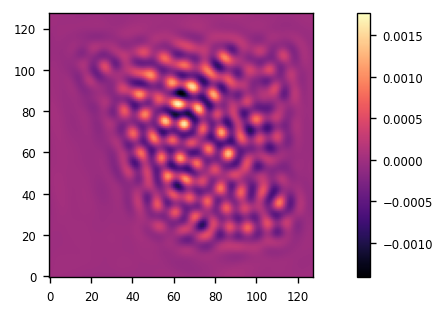

In [206]:
imshow(μz.reshape(L,L))
colorbar()

In [207]:
var(μz)

6.132984562084967e-08

In [208]:
'''
to go from z to w we divide by L
to go from w to z we multiply by L
'''
λz = exp((μz+μ0z+vz/2))
mean(λz)

0.10337378514335949

In [209]:
mean(y)

0.049783458158045454

In [210]:
var(μ0z)

0.06032374341093734

In [211]:
var(μz)

6.132984562084967e-08

In [212]:
var(μ0w)

3.6818691046714684e-06

In [213]:
var(μw)

1.886041849413764e-11

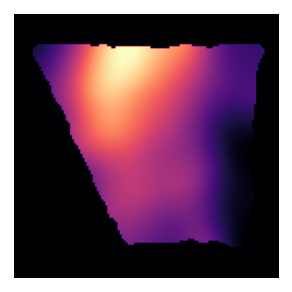

In [214]:
showim( exp((μz+μ0z+vz/2)).reshape(L,L),mask=mask)

# Sweep β and optimize 

In [67]:
# For jupyter notebooks: trigger browser to notify when done
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js('''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''.format(text=text)))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    #clear_output(False)
def notify(what='attention'):
    #os.system("echo -n '\a'")
    speak(what+'!')

In [69]:
results = []
for i,β in enumerate(βs):
    μw,vz,l = infer(μw,vz,β,P)
    results += [(μw,vz,l)]
notify('DONE')

(initializing)
(getting variance)
(optimizing)
μ 0.00011029853390784364 iteration 0 0
μ 1.656076431260739e-07 iteration 0 1
(getting variance)
Iteration 0
Δv 3.3036595570301586e-08
Δμ 2.6449518335587686e-10
(initializing)
(getting variance)
(optimizing)
μ 1.1758851647853185e-05 iteration 0 0
(getting variance)
Iteration 0
Δv 6.394391613429029e-09
Δμ 2.0505865422484333e-08
(initializing)
(getting variance)
(optimizing)
μ 1.5491945074541552e-05 iteration 0 0
(getting variance)
Iteration 0
Δv 9.741541462382486e-09
Δμ 3.1153524882680834e-08
(initializing)
(getting variance)
(optimizing)
μ 2.0438445938913535e-05 iteration 0 0
(getting variance)
Iteration 0
Δv 1.4851778987190478e-08
Δμ 4.7453259703803284e-08
(initializing)
(getting variance)
(optimizing)
μ 2.7001985810110997e-05 iteration 0 0
(getting variance)
Iteration 0
Δv 2.2662017928887224e-08
Δμ 7.247800910103547e-08
(initializing)
(getting variance)
(optimizing)
μ 3.5724218062468146e-05 iteration 0 0
μ 1.1101897828922286e-07 iteration

<IPython.core.display.Javascript object>

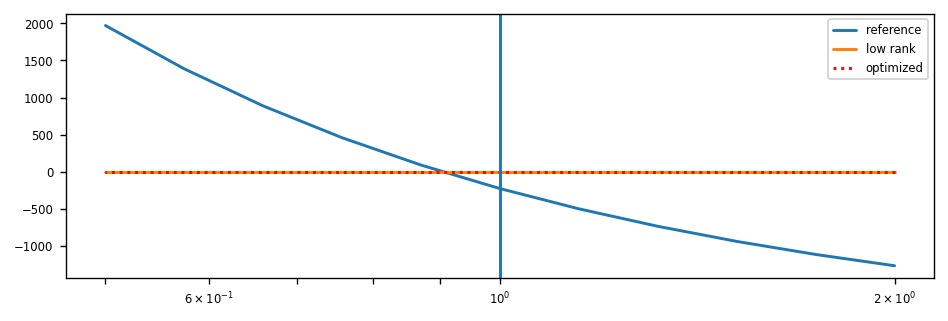

In [70]:
l = array([r[2] for r in results])
l1 = sum(l[:,:5],1)
l2 = sum(l[:,5:10],1)
l3 = sum(l[:,10:],1)
plot(βs,l1 - mean(l1),label='reference')
plot(βs,l2 - mean(l2),label='low rank')
plot(βs,l3 - mean(l3),label='optimized',linestyle=':',color='r')
semilogx()
axvline(1)
legend()

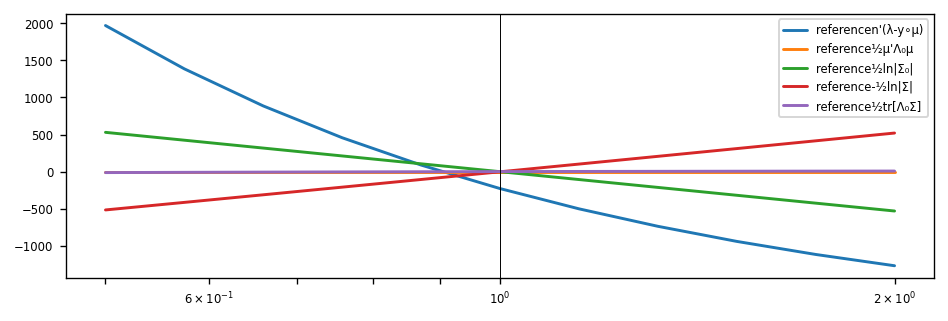

In [71]:
for i,name in enumerate("n'(λ-y∘μ)  ½μ'Λ₀μ ½ln|Σ₀| -½ln|Σ| ½tr[Λ₀Σ]".split()):
    plot(βs,l[:,i]-mean(l[:,i]),label='reference'+name)
    #plot(βs,l[:,i+5]-mean(l[:,i+5]),label='low-rank'+name)
    #plot(βs,l[:,i+10]-mean(l[:,i+10]),label='optimized'+name)
legend()
semilogx()
axvline(1,lw=0.5,color='k')
    

IndexError: index 5 is out of bounds for axis 1 with size 5

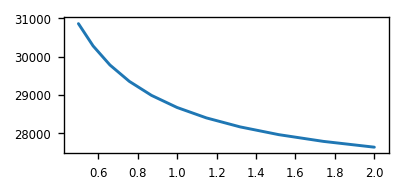

In [72]:
figure(figsize=(3,9))

for i,name in [*enumerate("n'(λ-y∘μ)  ½μ'Λ₀μ ½ln|Σ₀| -½ln|Σ| ½tr[Λ₀Σ]".split())][:-2]:
    subplot(6,1,i+1)
    plot(βs,l[:,i],label='reference')
    plot(βs,l[:,i+5],label='low-rank')
    plot(βs,l[:,i+10],label='optimized')
    title(name)
    legend()
    semilogx()
    axvline(1,lw=0.5,color='k')
    
subplot(614)
    
plot(βs,l[:,2]+l[:,3],label='reference')
plot(βs,l[:,2+5]+l[:,3+5],label='low-rank')
plot(βs,l[:,2+10]+l[:,3+10],label='optimized')
title("½ln|Σ₀|-½ln|Σ|")
legend()
semilogx()
axvline(1,lw=0.5,color='k')

tight_layout()

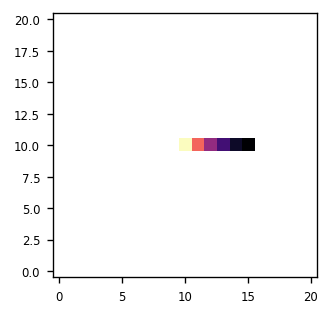

P[10]=8.94 β[16]=0.66
(initializing)
(getting variance)
(optimizing)
μ 0.011564751002006466 iteration 0 0
(getting variance)
Iteration 0
Δv 1.2645099650182567e-05
Δμ 1.160912934139667e-05


In [ ]:
from IPython.display import clear_output

ip = NP//2
iβ = Nβ//2
p  = Ps[ip]
β  = βs[iβ]

μ,v,l = infer(μ,v,float(β),float(p))
print('\tβ[%d] ='%iβ,β,'\tloss = ',l)
μref,vref = μ,v

results = np0.empty((NP,Nβ),dtype='object')
def current_best():
    global results
    losses  = array([inf if r is None else np.sum(array(r[2])) for r in results.ravel()])
    bestidx = argmin(losses)
    bestP,bestβ = unravel_index(bestidx,results.shape)
    return bestP, bestβ, losses[bestidx]  
def search(ip,iβ,suggested_direction=None):
    global results
    # Return if out of bounds; Return memoized if possible; 
    if iβ<0 or ip<0 or iβ>=Nβ or ip>=NP: return
    if results[ip,iβ]: return
    
    print('P[%d]=%0.2f β[%d]=%0.2f'%(ip,Ps[ip],iβ,βs[iβ]))
    

    # Get initial conditions via extrapolation when possible
    if iβ+2<Nβ and results[ip,iβ+1] and results[ip,iβ+2]:
        (μ1,v1),(μ2,v2) = results[ip,iβ+1][:2], results[ip,iβ+2][:2]
        μ = 2*μ1 - μ2
        v = 2*v1 - v2
    elif iβ>=2 and results[ip,iβ-1] and results[ip,iβ-2]:
        (μ1,v1),(μ2,v2) = results[ip,iβ-1][:2], results[ip,iβ-2][:2]
        μ = 2*μ1 - μ2
        v = 2*v1 - v2
    elif iβ+1<Nβ and results[ip,iβ+1]: μ,v = results[ip,iβ+1][:2]
    elif iβ>=1   and results[ip,iβ-1]: μ,v = results[ip,iβ-1][:2]
    elif ip+1<NP and results[ip+1,iβ]: μ,v = results[ip+1,iβ][:2]
    elif ip>=1   and results[ip-1,iβ]: μ,v = results[ip-1,iβ][:2]
    else: μ,v = μref,vref
    
    β = βs[iβ]
    μ,v,l = infer(μ,v,float(β),float(p))
    results[ip,iβ] = (μ,v,l)
    print('P[%d]=%0.2f β[%d]=%0.2f loss=%f'%(ip,Ps[ip],iβ,βs[iβ],np.sum(array(l))))
    clear_output(wait=True)
    figure()
    imshow(array([sum(array(r[2])) if not r is None else nan for r in results.ravel()]).reshape(NP,Nβ))
    show()
    
    # Recursively search nearby
    search_directions = {(0,1),(0,-1),(1,0),(-1,0)}
    # Continue along previous trajectory, if any
    if not suggested_direction is None:
        Δp,Δβ = suggested_direction
        if current_best()[:2]==(ip,iβ):
            search(ip+Δp,iβ+Δβ,suggested_direction=(Δp,Δβ))
            search_directions -= {(Δp,Δβ)}
    # Try other trajectories
    for Δp,Δβ in search_directions:
        if current_best()[:2]!=(ip,iβ): break
        search(ip+Δp,iβ+Δβ,suggested_direction=(Δp,Δβ))
    return

ip = NP//2
iβ = Nβ//2
search(ip,iβ)

notify('DONE')

In [ ]:
bestP, bestβ = current_best()[:2]
μ,v,l = results[bestP,bestβ]
λ = exp(μ + μ0 + v/2)
subplot(121)
showim(λ.reshape(L,L),mask=mask)
subplot(122)
showim(1/v.reshape(L,L),mask=mask)
print('Optimized kernel height β=%f'%βs[bestβ])
print('Optimized kernel period P=%f'%Ps[bestP])

In [ ]:
imshow(μ.reshape(L,L))
colorbar()

In [ ]:
p = Ps[bestP]

In [ ]:
β = βs[bestβ]

In [ ]:
'''
Use low-pass filtered velocity angle as heading 
Positive dx is eastwards
Negative dx is westwards
Positive dy is northwards
Negative dy is southwards
Angle is computed as if a complex number
North is +90, West is ±180, South is -90, and East is 0.
So, sin(θ) is the vertical direction, with sin(θ)=1 being northwards.
Likewise cos(θ) is the horizontal direction, with cos(θ)=1 being eastwards.
North: positive sin(θ)
South: negative sin(θ)
East : positive cos(θ)
West : negative cos(θ)
φ=0    : West
φ=1/2π : South
φ=π    : East
φ=3/2π : North
'''
φW,φS,φE,φN = 0, pi/2, pi, 3*pi/2
φs  = linspace(0,2*pi,90+1)[:-1]
φiW = argmin(abs(φs-φW))
φiS = argmin(abs(φs-φS))
φiE = argmin(abs(φs-φE))
φiN = argmin(abs(φs-φN))